In [105]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.special import gamma
import numpy.linalg as la
import sys
from matplotlib import ticker
import matplotlib
from IPython.core.display import Latex
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from numpy import linalg as la

In [106]:
def fastplot(x,y,xlabel='',ylabel=''):
    fig, ax = plt.subplots()
    ax.scatter(x,y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    return fig, ax

# Forward Problem (Analytical) 

In [107]:
v1,v2 = 6.,6.3
x1,x2,z1,z2 = 4,7,1,9
ds1 = 0
ds2 = 1/v1-1/v2
def forward_l(zr,x1,x2,z1,z2,right):
    if right:
        a = x1
        b = x2
        x1 = 13-b
        x2 = 13-a
    dx = x2-x1
    if zr<=(x1+z1):
        t = np.sqrt(2)*zr*ds1
    elif zr>(x1+z1) and zr<=(x2+z1):
        t = np.sqrt(2)*((x1+z1)*ds1+(zr-z1-x1)*ds2)
    else:
        t = np.sqrt(2)*((zr-dx)*ds1+dx*ds2)
    return t

def forward_sim(G,s):
    return G@s

In [108]:
rays = np.arange(2,12)
t_l = [forward_l(r,x1,x2,z1,z2,False) for r in rays]
t_r = [forward_l(r,x1,x2,z1,z2,True) for r in rays]
rays_all = np.arange(20)#rays are enumerated top to bottom starting on the left assigning 0-9 and 10-19 on the right
t_pure = np.concatenate((t_l,t_r))
t_pure.shape

(20,)

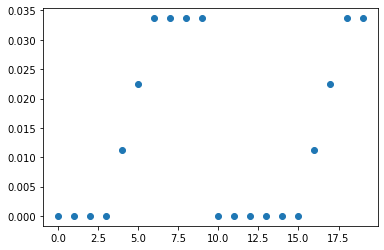

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [109]:
fastplot(rays_all, t_pure)

### Adding noise

We draw numbers from the distribution:\
$ g(x) = \frac{1}{\sigma\sqrt{2\pi}} exp\left(\frac{-x^2}{2\sigma^2} \right)$\
To determine the std we compute the expectation value of the length of the vector:\
$\mathbb{E}\left[||x||_2^n\right] = 2^\frac{n-2}{2}\sigma^n N \frac{\Gamma\left(\frac{N+n}{2}\right)}{\Gamma\left(\frac{N+2}{2}\right)} = \sigma 20 \frac{\Gamma\left(\frac{21}{2}\right)}{\Gamma\left(11\right)\sqrt{2}}$\
$\sigma = \frac{\Gamma(11)\sqrt{2}}{20^2\Gamma(21/2)}\cdot||t||$

In [110]:
S = np.zeros((11,13)) 
S[1:9,4:7] = ds2
s_sim = np.ndarray.flatten(S) #s_sim contains information about the size of the gray area and is used to simulate the data"

In [111]:
G = np.zeros((20,13*11))
G[np.arange(10),np.arange(1,11)] = np.sqrt(2)
G[np.arange(10,20,1),np.arange(11,1,-1)] = np.sqrt(2)
for i in range(10):
    G[np.arange(i,10), np.arange(13*(i+1),11+12*(i+1))] = np.sqrt(2)
    G[np.arange(10+i,20),np.arange(25+13*i,15+i*14,-1)] = np.sqrt(2)

In [112]:
#np.random.seed(10)
N = 20
sigma = 0.001#gamma((N+2)/2)*np.sqrt(2)/ (20*N*gamma((N+1)/2))*la.norm(t_pure)
n = np.random.normal(loc = 0, scale = sigma, size = (N))
t_pure = np.dot(G,s_sim)
t = t_pure + n
t = t.reshape((len(t),1))
t_pure_sim = forward_sim(G,s_sim)
la.norm(n)-1/20*la.norm(t_pure), sigma, la.norm(t_pure_sim-t_pure)

(0.00041320276329362155, 0.001, 0.0)

# Discretization of the problem 

Discretization allows us to formulate the problem as:\
$\vec{t} = \mathbf{G}\vec{s}$\
slowness on the 13x11 square grid is aranged in the following way\
[[s0,s1,s2,...,s12],\
[s13,s14,...,s25],\
...[...,s143]...
]\
which is stored in the vector s= [s1,s2,...,s143]

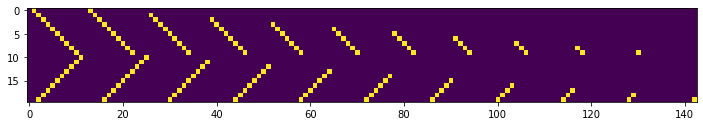

In [113]:
#This is what the matrix looks like
fig, ax = plt.subplots(figsize = (12,14))
ax.imshow(G)
#ax.set_title('G matrix')

#cbar = fig.colorbar(neg, ax=ax, shrink = 0.3)
#cbar.ax.set_ylabel(fontsize = 22)
#cbar.ax.tick_params(labelsize=20) 
#cbar.ax.yaxis.get_offset_text().set_fontsize(20)
#cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
#cbar.formatter.set_powerlimits((0, 0))
#cbar.update_ticks()
fig.savefig("G_matrix.png", dpi = 400)
plt.show()

# Solve IP 

In [115]:
def Tikh_solution(M,d,eps):
    """Linear IP solver. Takes matrix M and data and computes Tikhonov solution for model parameter x"""
    A = np.matmul(M.T,M)
    return  la.multi_dot([la.inv(A+eps**2*np.eye(len(A))),M.T,d])

def misfit(G,d,s): return np.abs(la.norm(d-np.matmul(G,s))**2-N*sigma**2)

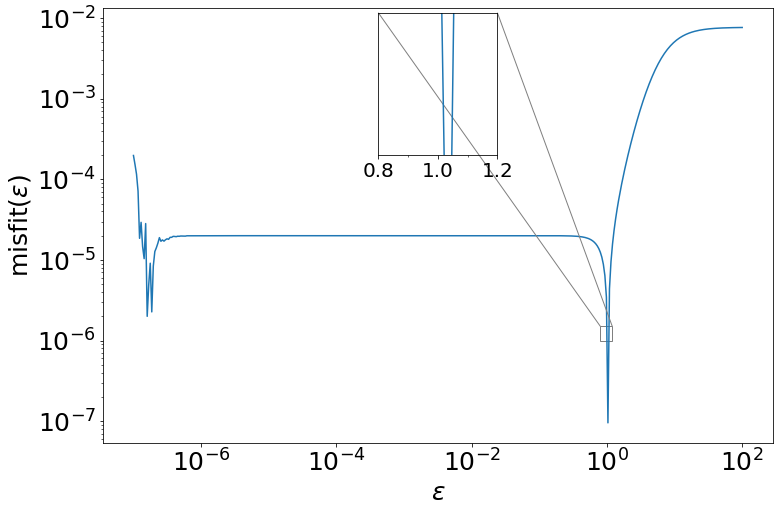

<Figure size 432x288 with 0 Axes>

In [133]:
Mis = []
Eps = np.logspace(-7,2,400)
for e in Eps:
    s_sim  = Tikh_solution(G,t,e)
    Mis.append(misfit(G, t,s_sim))
fig, ax = plt.subplots(figsize = (12,8))
Mis = np.array(Mis)
Eps = np.array(Eps)


ax.plot(Eps, Mis)
axins = zoomed_inset_axes(ax, 10, loc=9) 
axins.plot(Eps, Mis)
axins.set_xlim(0.8, 1.2) # Limit the region for zoom
axins.set_ylim(1e-6,1.5e-6)
mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.5")
#axins.set_yticks([])
axins.xaxis.set_major_locator(ticker.MultipleLocator(.2))
axins.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.tick_params(labelsize=25) 
axins.tick_params(labelsize=20) 
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$\mathrm{misfit}(\varepsilon)$', fontsize = 25)
ax.set_xlabel(r'$\varepsilon$', fontsize = 25)
axins.set_yticks([])
plt.yticks(visible=False)
plt.show()
plt.tight_layout()
fig.savefig('epsilon_misfit.png', dpi = 300)

In [ ]:
fig,ax = plt.subplots()
ax.plot(Eps, Mis)
ax.set_ylabel('misfit')
ax.set_xlabel(r'$\varepsilon$')
ax.set_yscale('log')
ax.set_xscale('log')
fig.savefig('epsilon.png')

In [ ]:
Mis = []
Eps = np.linspace(.1,4,200)
for e in Eps:
    s_sim  = Tikh_solution(G,t,e)
    Mis.append(misfit(G, t,s_sim))
fig,ax = plt.subplots()
ax.plot(Eps, Mis)
ax.set_ylabel('misfit')
ax.set_xlabel('epsilon')
ax.set_yscale('log')
#ax.set_xscale('log')
fig.savefig('epsilon_zoom.png')

In [37]:
eps = 1.035#.38e-7
s_f = Tikh_solution(G,t,eps)
#condition to fit parameters so that prediction is barely within uncertainty
print(f"misfit: {misfit(G,t,s_f):.2e}")
la.norm(s_f)

misfit: 8.76e-07


0.018389258889952697

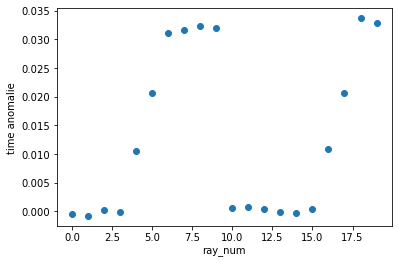

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='ray_num', ylabel='time anomalie'>)

In [38]:
t_pred = G@s_f
fastplot(rays_all,t_pred, xlabel = 'ray_num', ylabel = 'time anomalie')

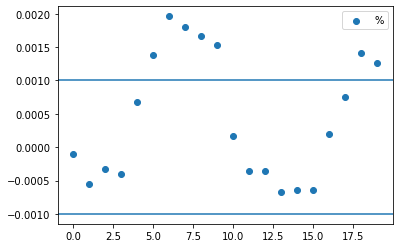

In [39]:
dt = (t-t_pred)
fig,ax = plt.subplots()
ax.scatter(rays_all, dt, label = '%')
ax.axhline(-sigma)
ax.axhline(sigma)
ax.legend()

In [53]:
s_mat_ma = np.ma.array(s_mat, mask = s_mat==0)

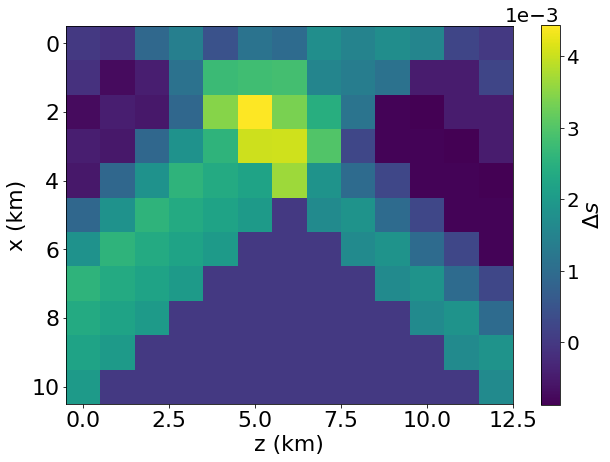

In [61]:
s_mat = np.reshape(s_f, (11,13))
fig,ax = plt.subplots(figsize = (10,10))
neg = ax.imshow(s_mat)
ax.set_xlabel('z (km)', fontsize = 22)
ax.set_ylabel('x (km)', fontsize = 22)
ax.tick_params(axis = 'both', labelsize = 22)
cbar = fig.colorbar(neg, ax=ax, shrink = 0.7)
cbar.ax.set_ylabel(r'$\Delta s$', fontsize = 22)
cbar.ax.tick_params(labelsize=20) 
cbar.ax.yaxis.get_offset_text().set_fontsize(20)
cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ax.set_title(r'')
fig.savefig('slowness_result.png', dpi = 300)

## Lets simulate a delta function

6.689975951684746e-10

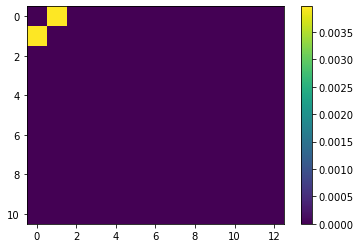

In [41]:
s_delta = np.ones((13*11,1))*ds1
s_delta[1] = ds2
t_delta = G@s_delta
eps = 1e-5
s_delta_pred = Tikh_solution(G,t_delta,eps)
S_delta_pred = np.reshape(s_delta_pred,(11,13))
fig,ax = plt.subplots()
neg = ax.imshow(S_delta_pred)
fig.colorbar(neg, ax=ax)
t_delta_pred = G@s_delta_pred
la.norm(t_delta_pred-t_delta)

Text(0, 0.5, 's_j')

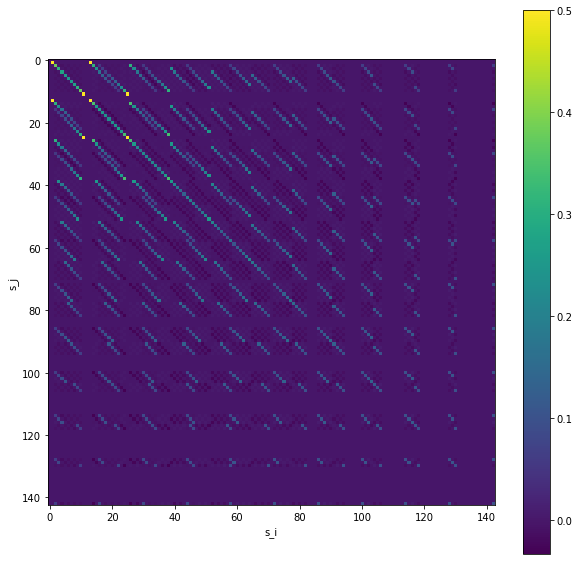

In [42]:
R = la.pinv(G)@G
fig,ax = plt.subplots(figsize = (10,10))
neg = ax.imshow(R)
fig.colorbar(neg, ax=ax)
ax.set_xlabel('s_i')
ax.set_ylabel('s_j')

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Use the colorbar set_ticks() method instead.
  # This is added back by InteractiveShellApp.init_path()


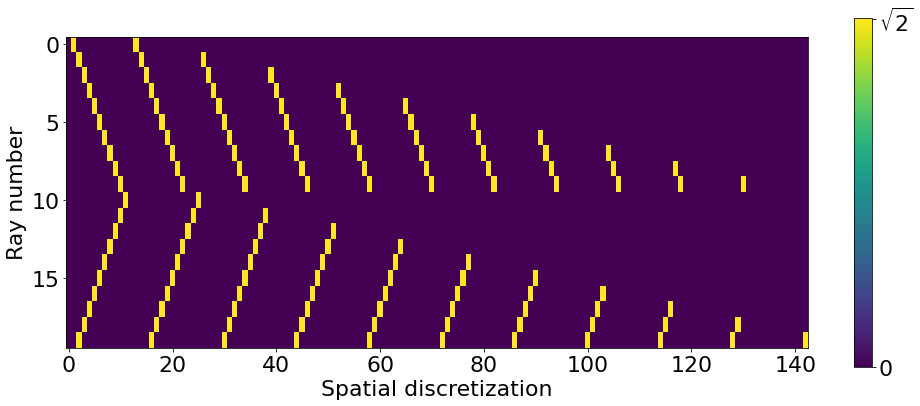

In [43]:
fig,ax = plt.subplots(figsize = (14,10))
neg = ax.imshow(G,aspect=3)
ax.set_xlabel('Spatial discretization', fontsize = 22)

ax.tick_params(axis = 'both', labelsize = 22)
cbar = fig.colorbar(neg, ax=ax, shrink = 0.5,ticks=[ 0, 1.41])
ax.set_ylabel('Ray number', fontsize = 22)
cbar.ax.tick_params(labelsize=22) 
#cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(.5))
#cbar.ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
cbar.ax.set_yticks([0,1.44])
cbar.ax.set_yticklabels(['0', '2'])
#cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
#cbar.formatter.set_powerlimits((0, 0))
#cbar.update_ticks()
#ax.set_xticks(np.arange(0,13,2))
#ax.set_xticklabels(np.arange(1,14,2))
#ax.set_yticks(np.arange(0,11,2))
#ax.set_yticklabels(np.arange(1,12,2))
#ax.set_title(r'')
plt.tight_layout()
cbar.ax.set_yticklabels(['0', r'$\sqrt{2}$'])
fig.savefig('G_mat.png', dpi = 400)

In [ ]:
R_rest = np.reshape(np.diag(R), (11,13))
s_mat = np.reshape(s_f, (11,13))
fig,ax = plt.subplots(figsize = (10,10))
neg = ax.imshow(R_rest)
ax.set_xlabel('x (km)', fontsize = 22)
ax.set_ylabel('z (km)', fontsize = 22)
ax.tick_params(axis = 'both', labelsize = 22)
cbar = fig.colorbar(neg, ax=ax, shrink = 0.7)
cbar.ax.set_ylabel(r'Resolution', fontsize = 22)
cbar.ax.tick_params(labelsize=20) 
cbar.ax.yaxis.get_offset_text().set_fontsize(20)
#cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
#cbar.formatter.set_powerlimits((0, 0))
#cbar.update_ticks()
ax.set_xticks(np.arange(0,13,2))
ax.set_xticklabels(np.arange(1,14,2))
ax.set_yticks(np.arange(0,11,2))
ax.set_yticklabels(np.arange(1,12,2))
#ax.set_title(r'')
plt.tight_layout()
fig.savefig('res_diag.png', dpi = 300)

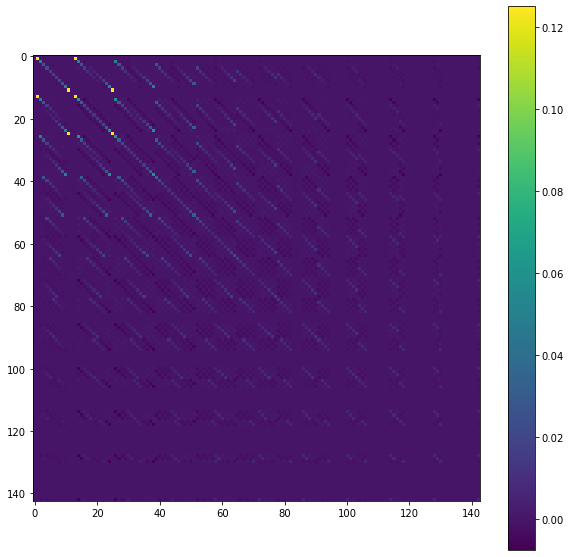

In [306]:
cov = la.pinv(G)@la.pinv(G).T
fig,ax = plt.subplots(figsize = (10,10))
neg = ax.imshow(cov)
fig.colorbar(neg, ax=ax)
#ax.set_xlabel('s_i')
#ax.set_ylabel('s_j')

## Try SVD 

In [101]:
U,S,Vh = la.svd(G)
Sig = np.eye(len(S))*S
print(la.inv(Sig).shape)
print(U.shape, S.shape, Vh.shape)

(20, 20)
(20, 20) (20,) (143, 143)


In [104]:
#try later

In [103]:
s_p = np.squeeze(Vh@s_f)
t_p = np.squeeze(U.T@t)
eps = 1.035
s_pred_p = t_p/S
s_pred = Vh.T@la.inv(Sig)@U.T@t

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 20 is different from 143)

In [77]:
s_mat = np.reshape(s_pred, (11,13))
fig,ax = plt.subplots(figsize = (10,10))
neg = ax.imshow(s_mat)
ax.set_xlabel('z (km)', fontsize = 22)
ax.set_ylabel('x (km)', fontsize = 22)
ax.tick_params(axis = 'both', labelsize = 22)
cbar = fig.colorbar(neg, ax=ax, shrink = 0.7)
cbar.ax.set_ylabel(r'$\Delta s$', fontsize = 22)
cbar.ax.tick_params(labelsize=20) 
cbar.ax.yaxis.get_offset_text().set_fontsize(20)
cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ax.set_title(r'')
fig.savefig('slowness_result.png', dpi = 300)

ValueError: cannot reshape array of size 20 into shape (11,13)